## Unpaired cysteine

In [ ]:
import concurrent.futures

from virtual_lab.constants import CONSISTENT_TEMPERATURE, CREATIVE_TEMPERATURE
from virtual_lab.prompts import create_merge_prompt
from virtual_lab.run_meeting import run_meeting
from virtual_lab.utils import load_summaries

from nanobody_constants import (
    num_iterations,
    num_rounds,
    discussions_phase_to_dir,
    principal_investigator,
    team_members,
)

In [2]:
# Unpaired cysteine - prompts
unpaired_cysteine_agenda = """Your team has designed 92 mutated nanobodies (23 each for the wild-type nanobodies H11-D4, Nb21, Ty1, and VHH-72) to improve their binding to the KP.3 variant of the SARS-CoV-2 spike protein receptor binding domain (RBD). Each nanobody has 1-4 mutations relative to the wild-type nanobody. Your team used ESM log-likelihood ratios (ESM LLR) to score the nanobody mutations independent of the antigen, AlphaFold-Multimer to predict the structure of the mutated nanobody in complex with the KP.3 RBD and compute the interface pLDDT (AF ipLDDT) as a metric of binding confidence, and Rosetta to calculate the binding energy of the mutated nanobody in complex with the KP.3 RBD (RS dG) based on the AlphaFold-Multimer predicted structure followed by a Rosetta relaxation. You have ranked the mutant nanobodies and selected the top ones using a weighted score of WS = 0.2 * (ESM LLR) + 0.5 * (AF ipLDDT) - 0. 3 * (RS dG).

An astute reviewer gave the following feedback: "The inclusion of an unpaired Cys in several of the engineered nanobodies would seem to be something that the ESM log-likelihood should have flagged as highly disfavored. Is there some other reason why the weighted score would rank these variants so highly, like the ipLDDT or dG values being very favorable? Are there any obvious adjustments to the WS formula that could mitigate this?"

Upon examining the 92 mutated nanobodies, your team found the following:

Nb21 and VHH-72 have no Cys changes (no additions or removals).

Among the 23 Ty21 mutants, two have an added Cys. The Ty1-V32C-G59H-H59Y mutant has an ESM LLR rank of 11 / 23, an AF ipLDDT rank of 22 / 23, and an RS DG rank of 1 / 23 while Ty1-V32C-G59D-D59Y mutant has an ESM LLR rank of 12 / 23, an AF ipLDDT rank of 23 / 23, and an RS DG rank of 2 / 23.

Among the H11-D4 mutants, three have an added Cys. The H11-D4-A14P-Y88V-R27C mutant has an ESM LLR rank of 19 / 23, an AF ipLDDT rank of 3 / 23, and an RS DG rank of 19 / 23 while the H11-D4-A14P-Y88V-R27C-W53Y mutant has an ESM LLR rank of 22 / 23, an AF ipLDDT rank of 8 / 23, and an RS DG rank of 6 / 23 and the H11-D4-A14P-Y88V-R27C-R52S mutant has an ESM LLR rank of 21 / 23, an AF ipLDDT rank of 18 / 23, and an RS DG rank of 12 / 23.

Based on the above information, how would you address the reviewer's questions?"""

unpaired_cysteine_questions = (
    "Is there some other reason why the weighted score would rank these variants so highly, like the ipLDDT or dG values being very favorable?",
    "Are there any obvious adjustments to the WS formula that could mitigate this?",
)

In [ ]:
# Unpaired cysteine - discussion
with concurrent.futures.ThreadPoolExecutor() as executor:
    concurrent.futures.wait([
        executor.submit(
            run_meeting,
            meeting_type="team",
            team_lead=principal_investigator,
            team_members=team_members,
            agenda=unpaired_cysteine_agenda,
            agenda_questions=unpaired_cysteine_questions,
            save_dir=discussions_phase_to_dir["unpaired_cysteine"],
            save_name=f"discussion_{iteration_num + 1}",
            temperature=CREATIVE_TEMPERATURE,
            num_rounds=num_rounds,
        ) for iteration_num in range(num_iterations)
    ])

In [ ]:
# Unpaired cysteine - merge
unpaired_cysteine_summaries = load_summaries(
    discussion_paths=list(discussions_phase_to_dir["unpaired_cysteine"].glob("discussion_*.json")))
print(f"Number of summaries: {len(unpaired_cysteine_summaries)}")

unpaired_cysteine_merge_prompt = create_merge_prompt(
    agenda=unpaired_cysteine_agenda,
    agenda_questions=unpaired_cysteine_questions,
)

run_meeting(
    meeting_type="individual", 
    team_member=principal_investigator,
    summaries=unpaired_cysteine_summaries,
    agenda=unpaired_cysteine_merge_prompt,
    save_dir=discussions_phase_to_dir["unpaired_cysteine"],
    save_name="merged",
    temperature=CONSISTENT_TEMPERATURE,
    num_rounds=num_rounds,
)

## ESM vs binding correlation

In [50]:
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

matplotlib.rcParams.update({'font.size': 22})

In [51]:
nanobodies = ["Nb21", "VHH-72", "H11-D4", "Ty1"]
variants = ["JN.1", "KP.3"]

experimental_data_dir = Path("experimental_data")

In [52]:
name_mapping = pd.read_csv(experimental_data_dir / "platemap.csv")

In [53]:
name_to_position = {
    row["Name"]: row["Well Location"]
    for _, row in name_mapping.iterrows()
}

In [54]:
nanobody_to_binding = {
    nanobody: pd.read_csv(experimental_data_dir / f"{nanobody}.txt", sep="\t").rename(columns={"Unnamed: 0": "position"}).drop(columns=["Unnamed: 1"]).set_index("position")
    for nanobody in nanobodies
}


In [55]:
nanobody_to_scores = {
    nanobody: pd.read_csv(f"designed/workflow_1/combined/{nanobody}.csv").set_index("name")
    for nanobody in nanobodies
}

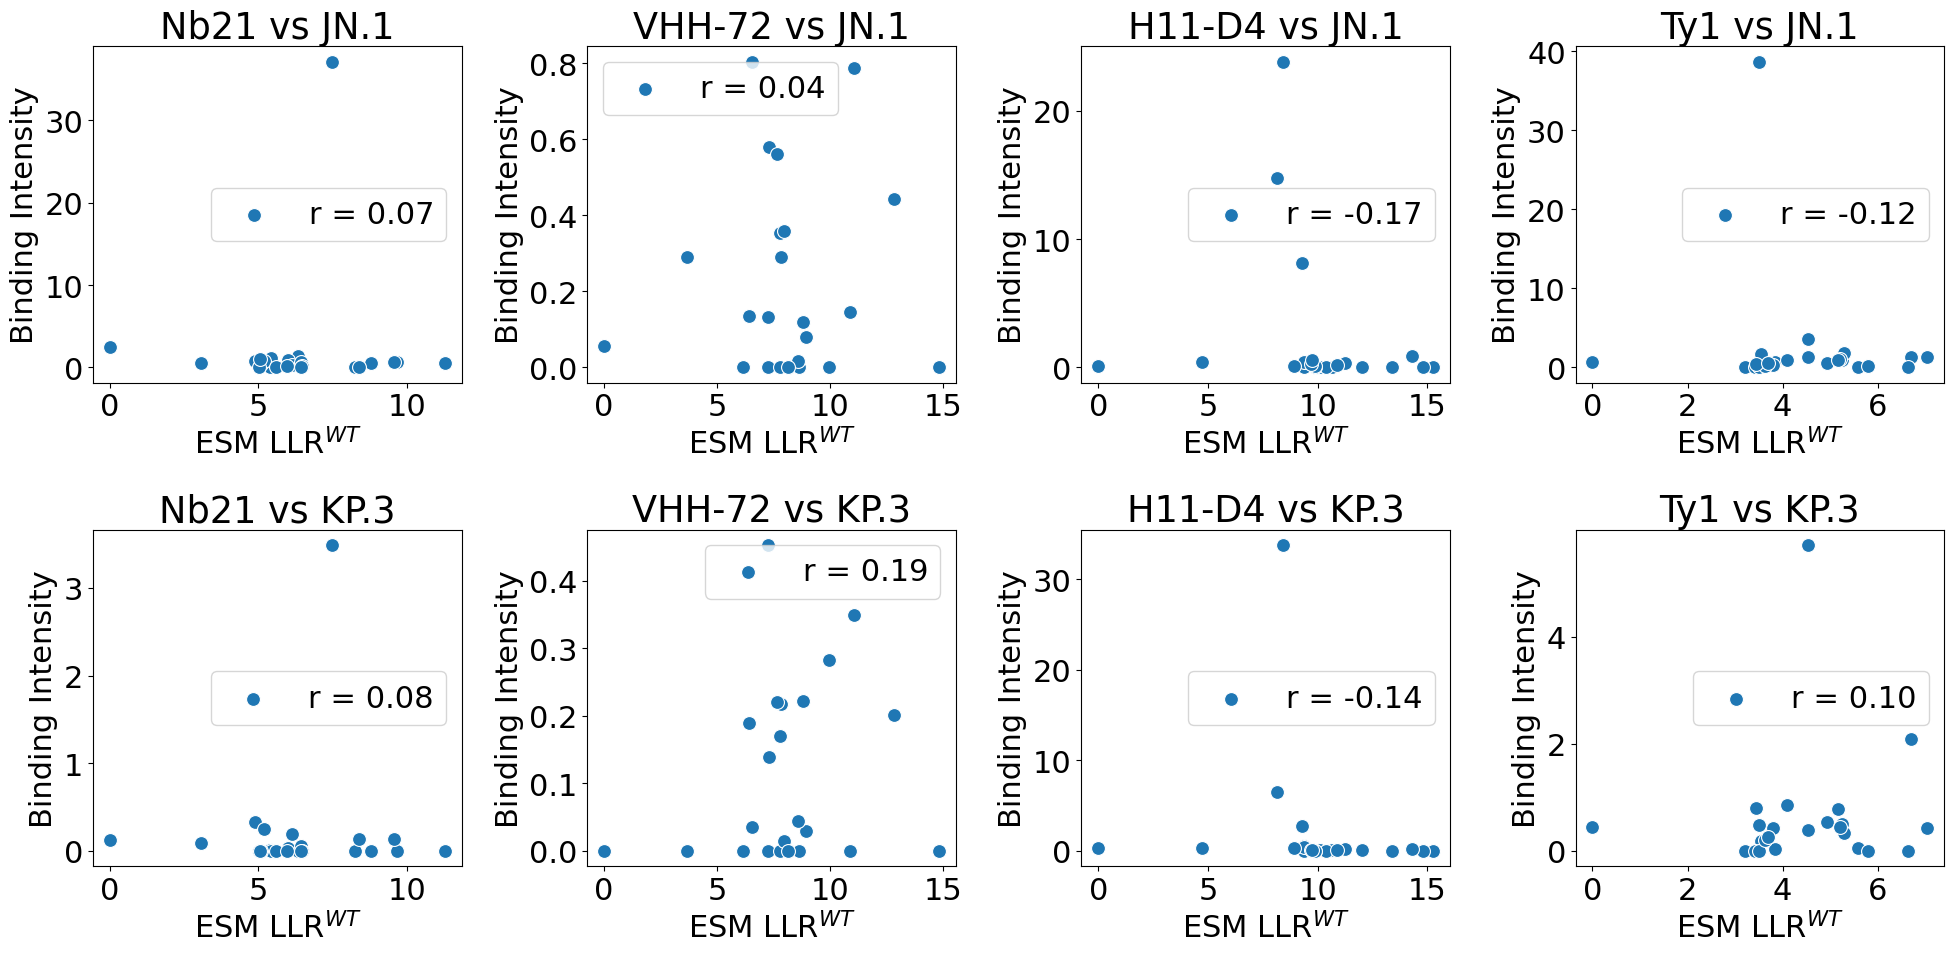

In [56]:
fig, axes = plt.subplots(len(variants), len(nanobodies), figsize=(20, 10))
axes = axes.flatten()

for i, variant in enumerate(variants):
    for j, nanobody in enumerate(nanobodies):
        plot_idx = i * 4 + j
        
        esm_scores = []
        binding_scores = []

        for name, position in name_to_position.items():
            if name.startswith(nanobody):
                esm_score = nanobody_to_scores[nanobody].loc[name, "log_likelihood_ratio_vs_wildtype"]
                binding_score = nanobody_to_binding[nanobody].loc[position, variant]
                esm_scores.append(esm_score)
                binding_scores.append(binding_score)

        scores = pd.DataFrame({"esm_score": esm_scores, "binding_score": binding_scores})
        correlation = scores["esm_score"].corr(scores["binding_score"])
        
        sns.scatterplot(x=esm_scores, y=binding_scores, s=100, label=f"r = {correlation:.2f}", ax=axes[plot_idx])
        axes[plot_idx].set_xlabel("ESM LLR$^{WT}$")
        axes[plot_idx].set_ylabel("Binding Intensity")
        axes[plot_idx].set_title(f"{nanobody} vs {variant}")
        axes[plot_idx].legend()

plt.tight_layout()
plt.show()